In [2]:
from common import *

os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "."
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

imported sthenogpax version


/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/_vendor/packaging/version.py:111: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  warnings.warn(


saving image to ./true_f_al_latexified.pdf
Figure size: [3.  1.5]


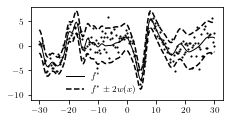

In [9]:
key = jax.random.PRNGKey(0)
num_inducing = 20
inducing_type = "random"
optimizer = optax.adam(learning_rate=0.01)
num_epochs = 1000
num_restarts = 10
flex_scale=True
flex_var=True
flex_noise=True
use_epistemic = False
n_initial = 30
n_selections = 50

scale_prior = tfb.Log()(tfd.Gamma(5.0, 1.0))
var_prior = tfb.Log()(tfd.Gamma(0.5, 1.0))
# var_prior = tfb.Log()(tfd.HalfCauchy(0.0, 1.0))
std_prior = tfd.Normal(0.0, 1.0)

B.epsilon = 1e-2

################ Simulated data
# X, y, true_f, lengthscale_trend, variance_trend, noise_var_trend = get_simulated_data1()
# X_test = jnp.linspace(-10, 10, 400).reshape(-1,1)

################

key = jax.random.PRNGKey(1221)
X, y, func_dict, true_f = get_synth1d(key=key, n_points=200)
X_test = X


def one_step(X, y, X_pool, train_bool=True, best_result_prev=None, best_params_prev=None):
    gp = get_gibbs_gp(X, flex_scale=flex_scale, flex_var=flex_var, flex_noise=flex_noise, 
                      num_inducing=min(X.shape[0], num_inducing), inducing_type=inducing_type)

    gp.kernel.active_dims = [0]
    if train_bool:
        loss_fn = get_loss_fn(gp, X, y, scale_prior=scale_prior, var_prior=var_prior, std_prior=std_prior)
        partial_initialize_params = jtu.Partial(initialize_params, gp=gp, X=X, scale_prior=scale_prior, var_prior=var_prior)
        keys = jax.random.split(key, num=num_restarts)
        raw_params = jax.vmap(partial_initialize_params)(key=keys)
        partial_train_fn = jtu.Partial(train_fn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs)
        result = jax.vmap(partial_train_fn)(raw_params=raw_params)
        best_result, best_raw_params = extract_results(result)
        best_params = constrain(best_raw_params, gp.get_bijectors())
    else:
        best_result = best_result_prev
        best_params = best_params_prev
    pred_mean, pred_cov = gp.predict(best_params, X, y, X_pool)
    return pred_mean, pred_cov, gp, best_params, best_result

X_train, X_pool, y_train, y_pool = train_test_split(X, y, random_state=3, train_size=n_initial)
# pred_mean, pred_cov, gp, best_params, best_result = one_step(X_train, y_train, X)
# plt.plot(best_result['loss_history']);
X.shape
(200, 1)
latexify(fig_width=3, fig_height=1.5)
fig, ax = plt.subplots()
ax.plot(X, true_f, '-', color='k', label=r'$f^*$', linewidth=1);
true_sd2 = 2*(func_dict['noise'](X)**0.5)
ax.scatter(X, y, marker='.', color='k', s=5);
ax.plot(X, true_f.ravel()-true_sd2.ravel(), '--', color='k', label=r"$f^* \pm 2w(x)$")
ax.plot(X, true_f.ravel()+true_sd2.ravel(), '--', color='k');
ax.set_ylim(-11,8)
# ax.plot(X, pred_mean, color='b');
# sd2 = 2 * (jnp.diag(pred_cov)**0.5)
# ax.fill_between(X.ravel(), pred_mean.ravel()-sd2, pred_mean.ravel()+sd2, alpha=0.4);
ax.legend(frameon=False, loc=(0.165, 0.02))
savefig('true_f_al')

In [10]:
print(X_pool.shape, y_pool.shape, X_train.shape, y_train.shape)
X_select = []
y_select = []
epi_var = []
pred_means = []

init = time()
for i in trange(n_selections):
    train_bool = True if i == 0 else False
    if train_bool:
        pred_mean, pred_cov, gp, best_params, best_result = one_step(
            X_train, y_train, X_pool, train_bool=train_bool
        )
    else:
        pred_mean, pred_cov, gp, best_params, best_result = one_step(
            X_train,
            y_train,
            X_pool,
            train_bool=train_bool,
            best_params_prev=best_params,
            best_result_prev=best_result,
        )
    if flex_noise is False:
        al_var = jnp.diag(pred_cov)
    else:
        if use_epistemic:
            al_var = jnp.diag(pred_cov) - gp.noise(best_params, X_pool).ravel()
        else:
            al_var = jnp.diag(pred_cov)

    pred_means.append(gp.predict(best_params, X_train, y_train, X, return_cov=False))
    epi_var.append(jnp.diag(gp.predict(best_params, X_train, y_train, X_test)[1]))
    al_ind = jnp.argmax(al_var)
    print("al_ind", al_ind)
    X_selected = X_pool[al_ind]
    y_selected = y_pool[al_ind]
    X_select.append(X_selected)
    y_select.append(y_selected)
    X_train = jnp.concatenate([X_train, X_selected.reshape(1, 1)])
    y_train = jnp.concatenate(
        [
            y_train,
            y_selected.reshape(
                1,
            ),
        ]
    )

    #     print(X_pool.shape, y_pool.shape, X_train.shape, y_train.shape)
    X_pool = jnp.delete(X_pool, al_ind, axis=0)
    y_pool = jnp.delete(y_pool, al_ind, axis=0)
    print(X_pool.shape, y_pool.shape, X_train.shape, y_train.shape)
print("Finished in", (time() - init) / 60, "minutes")


(170, 1) (170,) (30, 1) (30,)


  0%|          | 0/50 [00:00<?, ?it/s]

min_indices [597 414 507 465 322 605 977 237 999  -1]
individual restart losses [117.90224609 120.52741821 115.1858201  117.65938743 117.25155107
 117.12359336 116.58703815 117.12416152 120.40586306          nan]
best_restart 2 best_loss 115.18582009830564


  2%|▏         | 1/50 [00:18<15:19, 18.76s/it]

al_ind 168
(169, 1) (169,) (31, 1) (31,)


  4%|▍         | 2/50 [00:27<10:13, 12.78s/it]

al_ind 66
(168, 1) (168,) (32, 1) (32,)


  6%|▌         | 3/50 [00:34<07:54, 10.10s/it]

al_ind 163
(167, 1) (167,) (33, 1) (33,)


  8%|▊         | 4/50 [00:42<07:09,  9.33s/it]

al_ind 58
(166, 1) (166,) (34, 1) (34,)


 10%|█         | 5/50 [00:49<06:20,  8.45s/it]

al_ind 161
(165, 1) (165,) (35, 1) (35,)


 12%|█▏        | 6/50 [00:56<05:46,  7.86s/it]

al_ind 41
(164, 1) (164,) (36, 1) (36,)


 14%|█▍        | 7/50 [01:02<05:20,  7.45s/it]

al_ind 151
(163, 1) (163,) (37, 1) (37,)


 16%|█▌        | 8/50 [01:10<05:13,  7.45s/it]

al_ind 59
(162, 1) (162,) (38, 1) (38,)
al_ind 35


 18%|█▊        | 9/50 [01:17<04:59,  7.30s/it]

(161, 1) (161,) (39, 1) (39,)
al_ind 143


 20%|██        | 10/50 [01:23<04:46,  7.17s/it]

(160, 1) (160,) (40, 1) (40,)
al_ind 43


 22%|██▏       | 11/50 [01:30<04:36,  7.10s/it]

(159, 1) (159,) (41, 1) (41,)
al_ind 78


 24%|██▍       | 12/50 [01:37<04:22,  6.91s/it]

(158, 1) (158,) (42, 1) (42,)
al_ind 67


 26%|██▌       | 13/50 [01:43<04:10,  6.77s/it]

(157, 1) (157,) (43, 1) (43,)
al_ind 95


 28%|██▊       | 14/50 [01:51<04:11,  6.97s/it]

(156, 1) (156,) (44, 1) (44,)
al_ind 28


 30%|███       | 15/50 [01:58<04:03,  6.95s/it]

(155, 1) (155,) (45, 1) (45,)
al_ind 109


 32%|███▏      | 16/50 [02:07<04:18,  7.61s/it]

(154, 1) (154,) (46, 1) (46,)
al_ind 148


 34%|███▍      | 17/50 [02:13<04:01,  7.31s/it]

(153, 1) (153,) (47, 1) (47,)
al_ind 64


 36%|███▌      | 18/50 [02:21<03:56,  7.40s/it]

(152, 1) (152,) (48, 1) (48,)
al_ind 40


 38%|███▊      | 19/50 [02:28<03:44,  7.25s/it]

(151, 1) (151,) (49, 1) (49,)
al_ind 49


 40%|████      | 20/50 [02:35<03:34,  7.15s/it]

(150, 1) (150,) (50, 1) (50,)
al_ind 63


 42%|████▏     | 21/50 [02:42<03:30,  7.24s/it]

(149, 1) (149,) (51, 1) (51,)
al_ind 62


 44%|████▍     | 22/50 [02:49<03:20,  7.15s/it]

(148, 1) (148,) (52, 1) (52,)
al_ind 133


 46%|████▌     | 23/50 [02:56<03:11,  7.08s/it]

(147, 1) (147,) (53, 1) (53,)
al_ind 92


 48%|████▊     | 24/50 [03:03<03:01,  6.96s/it]

(146, 1) (146,) (54, 1) (54,)
al_ind 51


 50%|█████     | 25/50 [03:09<02:50,  6.80s/it]

(145, 1) (145,) (55, 1) (55,)
al_ind 95


 52%|█████▏    | 26/50 [03:16<02:40,  6.70s/it]

(144, 1) (144,) (56, 1) (56,)
al_ind 69


 54%|█████▍    | 27/50 [03:22<02:32,  6.62s/it]

(143, 1) (143,) (57, 1) (57,)
al_ind 115


 56%|█████▌    | 28/50 [03:29<02:24,  6.57s/it]

(142, 1) (142,) (58, 1) (58,)
al_ind 9


 58%|█████▊    | 29/50 [03:36<02:24,  6.90s/it]

(141, 1) (141,) (59, 1) (59,)
al_ind 123


 60%|██████    | 30/50 [03:43<02:17,  6.89s/it]

(140, 1) (140,) (60, 1) (60,)
al_ind 28


 62%|██████▏   | 31/50 [03:50<02:11,  6.91s/it]

(139, 1) (139,) (61, 1) (61,)
al_ind 44


 64%|██████▍   | 32/50 [03:57<02:03,  6.84s/it]

(138, 1) (138,) (62, 1) (62,)
al_ind 46


 66%|██████▌   | 33/50 [04:04<01:58,  6.95s/it]

(137, 1) (137,) (63, 1) (63,)
al_ind 39


 68%|██████▊   | 34/50 [04:11<01:50,  6.94s/it]

(136, 1) (136,) (64, 1) (64,)
al_ind 116


 70%|███████   | 35/50 [04:18<01:42,  6.85s/it]

(135, 1) (135,) (65, 1) (65,)
al_ind 26


 72%|███████▏  | 36/50 [04:24<01:36,  6.87s/it]

(134, 1) (134,) (66, 1) (66,)
al_ind 81


 74%|███████▍  | 37/50 [04:32<01:31,  7.04s/it]

(133, 1) (133,) (67, 1) (67,)
al_ind 110


 76%|███████▌  | 38/50 [04:39<01:24,  7.01s/it]

(132, 1) (132,) (68, 1) (68,)
al_ind 72


 78%|███████▊  | 39/50 [04:46<01:16,  6.98s/it]

(131, 1) (131,) (69, 1) (69,)
al_ind 71


 80%|████████  | 40/50 [04:53<01:09,  6.96s/it]

(130, 1) (130,) (70, 1) (70,)
al_ind 111


 82%|████████▏ | 41/50 [05:00<01:03,  7.05s/it]

(129, 1) (129,) (71, 1) (71,)
al_ind 121


 84%|████████▍ | 42/50 [05:07<00:56,  7.07s/it]

(128, 1) (128,) (72, 1) (72,)
al_ind 46


 86%|████████▌ | 43/50 [05:14<00:49,  7.02s/it]

(127, 1) (127,) (73, 1) (73,)
al_ind 118


 88%|████████▊ | 44/50 [05:21<00:41,  6.92s/it]

(126, 1) (126,) (74, 1) (74,)
al_ind 87


 90%|█████████ | 45/50 [05:28<00:35,  7.00s/it]

(125, 1) (125,) (75, 1) (75,)
al_ind 15


 92%|█████████▏| 46/50 [05:35<00:27,  6.97s/it]

(124, 1) (124,) (76, 1) (76,)
al_ind 113


 94%|█████████▍| 47/50 [05:42<00:20,  6.97s/it]

(123, 1) (123,) (77, 1) (77,)
al_ind 96


 96%|█████████▌| 48/50 [05:48<00:13,  6.87s/it]

(122, 1) (122,) (78, 1) (78,)
al_ind 12


 98%|█████████▊| 49/50 [05:56<00:07,  7.04s/it]

(121, 1) (121,) (79, 1) (79,)


100%|██████████| 50/50 [06:02<00:00,  7.26s/it]

al_ind 114
(120, 1) (120,) (80, 1) (80,)
Finished in 6.049489537874858 minutes


min_indices [462 533  -1 429 122 605 358 302 879  -1]
individual restart losses [208.97557379 213.30365099          nan 211.15984279 221.66239291
 210.3545835  225.14601471 205.44924978 229.91299218          nan]
best_restart 7 best_loss 205.44924978113568
saving image to ./use_epistemic=False_flex_scale=True_flex_var=True_flex_scale=True_new_latexified.pdf
Figure size: [3.  1.5]


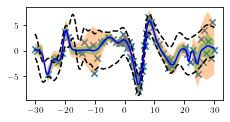

In [11]:
pred_mean, pred_cov, gp, best_params, best_result = one_step(X_train, y_train, X, train_bool=True)
latexify(fig_width=3, fig_height=1.5)
fig, ax = plt.subplots()

# ax.plot(X, true_f, color='k');
true_sd2 = 2*(func_dict['noise'](X)**0.5)
sd2 = 2 * (jnp.diag(pred_cov)**0.5)
sd2_epi = 2 * ((jnp.diag(pred_cov) - gp.noise(best_params, X))**0.5)

ax.scatter(X_train, y_train, marker='x', s=40);
ax.plot(X.ravel(), true_f.ravel()-true_sd2.ravel(), '--', color='k')
ax.plot(X, true_f.ravel()+true_sd2.ravel(), '--', color='k')
ax.fill_between(X.ravel(), pred_mean.ravel()-sd2, pred_mean.ravel()+sd2, alpha=0.4);
ax.fill_between(X.ravel(), pred_mean.ravel()-sd2_epi, pred_mean.ravel()+sd2_epi, alpha=0.4);

ax.plot(X, pred_mean, color='b');
# ax.legend();
savefig(f"{use_epistemic=}_{flex_scale=}_{flex_var=}_{flex_scale=}_new")

saving image to ./f_compare_latexified.pdf
Figure size: [3.  1.5]


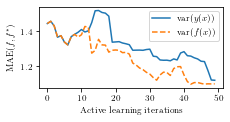

In [12]:
latexify(fig_width=3, fig_height=1.5)
if use_epistemic:
    epi_errors = jtu.tree_map(lambda pred_mean: jnp.abs(pred_mean.ravel()-true_f.ravel()).mean(), pred_means, is_leaf=lambda x: isinstance(x, tuple))
else:
    no_epi_errors = jtu.tree_map(lambda pred_mean: jnp.abs(pred_mean.ravel()-true_f.ravel()).mean(), pred_means, is_leaf=lambda x: isinstance(x, tuple))
# plt.plot(epi_errors, label='epi')
plt.plot(no_epi_errors, label=r'var$(y(x))$')
plt.plot(epi_errors, '--', label=r'var$(f(x))$')
plt.xlabel("Active learning iterations")
plt.ylabel("MAE$(f, f^*)$")
plt.legend();
savefig("f_compare")